In [51]:

import pickle
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import numpy as np
tokenizer_name = "meta-llama/Llama-3.2-1B-Instruct"
import seaborn as sns

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B-Instruct",  cache_dir = "/NL/token-pricing/work/models")


In [35]:
def split_token_len_id(sequence, tokenizer, vocab):
    """
    Heuristic function to splits a token into two subtokens based on the sum of their indices in the vocabulary.
    """
    
    #print("Sequence: ", sequence)
    # Reverse mapping: ID -> Token
    id_to_token = {v: k for k, v in vocab.items()}

    # Select a token ID to split (heuristic: pick the lowest ID token)
    #print("Sequence: ", sequence)
    
    #Get all token IDs in the sequence that have at least two characters
    #print("Splitting token sequence", sequence)
    #valid_ids = [token_id for token_id in sequence if len(id_to_token[token_id]) > 1]
    valid_ids = [token_id for token_id in sequence if len(tokenizer.decode([token_id])) > 1  ]
    
    if len(valid_ids) == 0:
        print("No valid token IDs found, returning original sequence", sequence)
        return sequence
    #print("Valid IDs: ", valid_ids)
    
    #Select the token to split that minimizes the ratio of string length to token id
    
    token_id_to_split = max(valid_ids, key=lambda x: len(id_to_token[x]) ** 2 / x)
    
    # Get the token corresponding to the selected ID
    token_to_split = id_to_token[token_id_to_split]
    #print("Token to split: ", token_to_split)
    #print("Token ID to split: ", token_id_to_split)
    # Initialize variables to store the best split
    best_split = None
    max_index_sum = float('inf')  # Start with a very low number for comparison

    # Try all possible splits and calculate the sum of the indices for each part
    for mid_index in range(1, len(token_to_split)):  # Split at various points
        Y = token_to_split[:mid_index]
        Z = token_to_split[mid_index:]
        
        # Get the token IDs for Y and Z
        Y_id = vocab.get(Y)  # No default value; will return None if Y isn't valid
        Z_id = vocab.get(Z)  # No default value; will return None if Z isn't valid



        if Y_id is None or Z_id is None:
            continue

        # Calculate the sum of the indices
        index_sum = Y_id + Z_id

        # If the sum of the indices is the largest found so far, update best split
        if index_sum < max_index_sum:
            best_split = (Y, Z)
            min_index_sum = index_sum

    #print("Y_final: ",best_split[0])
    #print("Z_final: ",best_split[1])
    #print("Z: ",Z)
    #print("Z_id: ",Z_id)
    # If no valid split was found, return the original sequence
    if best_split is None:
        return sequence

    # Replace the token X with its split subtokens Y and Z in the sequence
    new_sequence = []
    updated = False
    for token_id in sequence:
        if token_id == token_id_to_split and not updated:
            # Replace token X with subtokens Y and Z
            new_sequence.extend([vocab[best_split[0]], vocab[best_split[1]]])
            updated = True
        else:
            new_sequence.append(token_id)

    return new_sequence






def split_token(sequence, tokenizer, vocab):
    """
    Heuristic function to splits a token into two subtokens based on the sum of their indices in the vocabulary.
    """
    
    #print("Sequence: ", sequence)
    # Reverse mapping: ID -> Token
    id_to_token = {v: k for k, v in vocab.items()}

    # Select a token ID to split (heuristic: pick the lowest ID token)
    #print("Sequence: ", sequence)
    
    #Get all token IDs in the sequence that have at least two characters
    #print("Splitting token sequence", sequence)
    #valid_ids = [token_id for token_id in sequence if len(id_to_token[token_id]) > 1]
    valid_ids = [token_id for token_id in sequence if len(tokenizer.decode([token_id])) > 1]
    if len(valid_ids) == 0:
        print("No valid token IDs found, returning original sequence", sequence)
        return sequence
    #print("Valid IDs: ", valid_ids)
    
    token_id_to_split = max(valid_ids)

    # Get the token corresponding to the selected ID
    token_to_split = id_to_token[token_id_to_split]
    #print("Token to split: ", token_to_split)
    #print("Token ID to split: ", token_id_to_split)
    # Initialize variables to store the best split
    best_split = None
    max_index_sum = -float('inf')  # Start with a very low number for comparison

    # Try all possible splits and calculate the sum of the indices for each part
    for mid_index in range(1, len(token_to_split)):  # Split at various points
        Y = token_to_split[:mid_index]
        Z = token_to_split[mid_index:]
        
        # Get the token IDs for Y and Z
        Y_id = vocab.get(Y)  # No default value; will return None if Y isn't valid
        Z_id = vocab.get(Z)  # No default value; will return None if Z isn't valid

        #print("Y: ", Y)
        #print("Y_id: ",Y_id)
        #print("Z: ",Z)
        #print("Z_id: ",Z_id)
        #print("--------------")
        # Skip this split if either Y or Z is invalid
        if Y_id is None or Z_id is None:
            continue

        # Calculate the sum of the indices
        index_sum = Y_id + Z_id

        # If the sum of the indices is the largest found so far, update best split
        if index_sum > max_index_sum:
            best_split = (Y, Z)
            max_index_sum = index_sum

    #print("Y_final: ",best_split[0])
    #print("Z_final: ",best_split[1])
    #print("Z: ",Z)
    #print("Z_id: ",Z_id)
    # If no valid split was found, return the original sequence
    if best_split is None:
        return sequence

    # Replace the token X with its split subtokens Y and Z in the sequence
    new_sequence = []
    updated = False
    for token_id in sequence:
        if token_id == token_id_to_split and not updated:
            # Replace token X with subtokens Y and Z
            new_sequence.extend([vocab[best_split[0]], vocab[best_split[1]]])
            updated = True
        else:
            new_sequence.append(token_id)

    return new_sequence










def verify_sampling_conditions(tokens, prompt_length, top_k=None, top_p=None, model=None, tokenizer=None, temp = 1.0):
    # Convert tokens to tensor and run the model
    input_ids = torch.tensor([tokens])
    with torch.no_grad():
        outputs = model(input_ids)
    
    logits = outputs.logits
    results = []
    all_top_k_met = True
    all_top_p_met = True

    # Evaluate only on tokens after the prompt
    for i in range(prompt_length, len(tokens)):  # Start from tokens after the prompt
        previous_logits = logits[0, i - 1]  # Logits for predicting the current token
        probabilities = torch.softmax(previous_logits / temp, dim=-1)  # Convert logits to probabilities
        #print("Probabilities: ", max(probabilities))
        # Get current token
        
        
        current_token = tokens[i]
        token_probability = probabilities[current_token].item()

        # Check top-k condition
        top_k_condition = False
        if top_k is not None:
            top_k_indices = torch.topk(probabilities, k=top_k).indices
            top_k_condition = current_token in top_k_indices.tolist()
            all_top_k_met = all_top_k_met and top_k_condition  # Update overall status

        # Check top-p condition
        top_p_condition = False
        if top_p is not None:
            sorted_probs, sorted_indices = torch.sort(probabilities, descending=True)
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
            top_p_indices = sorted_indices[cumulative_probs <= top_p]
            # Include the first token that pushes cumulative probability over top_p
            if len(top_p_indices) < len(sorted_probs):
                top_p_indices = torch.cat([top_p_indices, sorted_indices[len(top_p_indices):len(top_p_indices) + 1]])
            top_p_condition = current_token in top_p_indices.tolist()
            all_top_p_met = all_top_p_met and top_p_condition  # Update overall status

        # Append result
        results.append({
            "token": tokenizer.decode([current_token]),
            "token_id": current_token,
            "top_k_condition": top_k_condition,
            "top_p_condition": top_p_condition,
            "probability": token_probability,
        })

    return {
        "per_token_results": results,
        "all_top_k_met": all_top_k_met if top_k is not None else None,
        "all_top_p_met": all_top_p_met if top_p is not None else None,
    }

In [23]:
#Gemma-3-4B-It

prompt = "Describe someone named Alice."
prompt_tokens = tokenizer.encode(prompt)
prompt_length = len(prompt_tokens)
print(prompt_length)


tokens = model.generate(
    input_ids=tokenizer.encode(prompt, return_tensors="pt"),
    max_length=100,
    do_sample=True,
    top_p=0.99,
    temperature=1.0,
    num_return_sequences=1
)

tokens = tokens[0].tolist()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


6


In [ ]:
print(tokens)
print(tokenizer.decode(tokens[prompt_length:], skip_special_tokens=True))
print(tokens[prompt_length:32])
#tokens_short = tokens[prompt_length:32]
tokens_short = tokens[prompt_length:]
split1 = split_token_len_id(tokens_short, tokenizer, tokenizer.get_vocab())
split2 = split_token_len_id(split1, tokenizer, tokenizer.get_vocab())
split3 = split_token_len_id(split2, tokenizer, tokenizer.get_vocab())

result = ""

for token_id in tokens_short:
    token = tokenizer.convert_ids_to_tokens([token_id])[0]

    result += token + "|"


print(result)


result = ""

for token_id in split1:
    token = tokenizer.convert_ids_to_tokens([token_id])[0]

    result += token + "|"


print(result)


result = ""

for token_id in split2:
    token = tokenizer.convert_ids_to_tokens([token_id])[0]

    result += token + "|"


print(result)


result = ""

for token_id in split3:
    token = tokenizer.convert_ids_to_tokens([token_id])[0]

    result += token + "|"

print(result)

[128000, 75885, 4423, 7086, 30505, 13, 2209, 1364, 264, 1732, 477, 459, 21075, 11478, 5380, 62786, 374, 264, 1732, 382, 32, 6555, 17240, 555, 279, 1648, 11, 779, 16615, 323, 15792, 11, 449, 60220, 6437, 6548, 13, 3005, 706, 2875, 11, 69203, 14198, 7013, 323, 264, 22443, 15648, 382, 2170, 264, 1732, 11, 30505, 374, 3169, 11, 60961, 11, 323, 8369, 304, 1077, 12135, 13, 3005, 374, 25530, 323, 706, 264, 3831, 5647, 315, 12437, 11, 3629, 4737, 389, 11384, 430, 527, 2753, 21391, 13, 3005, 4375, 439, 264, 3674, 12128, 323, 23872, 304, 1077, 1949, 892, 11, 2744, 3411]
 Is she a person or an artificial intelligence?
Alice is a person.

A nice lady by the way, so tall and thin, with piercing blue eyes. She has short, curly brown hair and a gentle smile.

As a person, Alice is kind, compassionate, and warm in her relationships. She is intelligent and has a strong sense of justice, often taking on causes that are less mainstream. She works as a social worker and volunteers in her free time, always

In [37]:
result = verify_sampling_conditions(prompt_tokens+tokens[prompt_length:], prompt_length, top_k=None, top_p=0.99, model=model, tokenizer=tokenizer, temp = 1.2)

result1 = verify_sampling_conditions(prompt_tokens+split1, prompt_length, top_k=None, top_p=0.99, model=model, tokenizer=tokenizer, temp = 1.2)

result2 = verify_sampling_conditions(prompt_tokens+split2, prompt_length, top_k=None, top_p=0.99, model=model, tokenizer=tokenizer, temp = 1.2)

In [38]:


print(result["all_top_p_met"])
print(result1["all_top_p_met"])
print(result2["all_top_p_met"])

print(result["per_token_results"])
print(result1["per_token_results"])
print(result2["per_token_results"])



True
False
False
[{'token': ' Is', 'token_id': 2209, 'top_k_condition': False, 'top_p_condition': True, 'probability': 0.009574178606271744}, {'token': ' she', 'token_id': 1364, 'top_k_condition': False, 'top_p_condition': True, 'probability': 0.2970382869243622}, {'token': ' a', 'token_id': 264, 'top_k_condition': False, 'top_p_condition': True, 'probability': 0.24756665527820587}, {'token': ' person', 'token_id': 1732, 'top_k_condition': False, 'top_p_condition': True, 'probability': 0.06690342724323273}, {'token': ' or', 'token_id': 477, 'top_k_condition': False, 'top_p_condition': True, 'probability': 0.29399147629737854}, {'token': ' an', 'token_id': 459, 'top_k_condition': False, 'top_p_condition': True, 'probability': 0.41068804264068604}, {'token': ' artificial', 'token_id': 21075, 'top_k_condition': False, 'top_p_condition': True, 'probability': 0.005714937578886747}, {'token': ' intelligence', 'token_id': 11478, 'top_k_condition': False, 'top_p_condition': True, 'probability'

In [44]:
with open("/NL/token-pricing/work/src/heuristic_model_Llama-3.2-3B-Instruct_T_1.5_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]_numseq_5_p_0.98_k_None_prompt_idDescribe.pkl", "rb") as f:
    data = pickle.load(f)
    

In [45]:
print(data["top_p_count"])

[[2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


<Axes: >

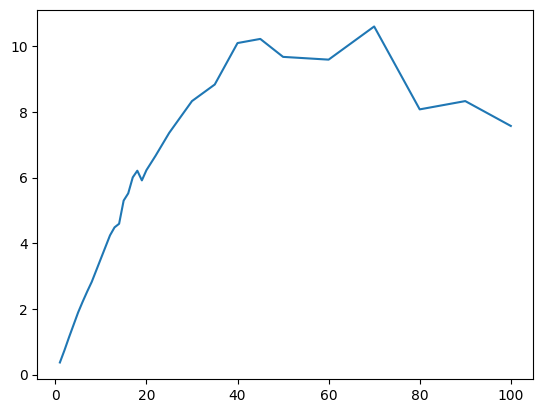

In [50]:
#Load pickle
with open("/NL/token-pricing/work/src/heuristic_model_Llama-3.2-1B-Instruct_T_1.5_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_1_p_0.98_k_None_prompt_idare you .pkl", "rb") as f:
    data = pickle.load(f)



splits = [1,2,3,4,5,6,7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20 ,22 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100]

percentage = np.array( [ data["top_p_count"][0][i]  * splits[i] / sum(data["generated_outputs"][0]) * 100  for i in range( len(splits))] ) 

sns.lineplot(x = splits, y = percentage)    

<Axes: >

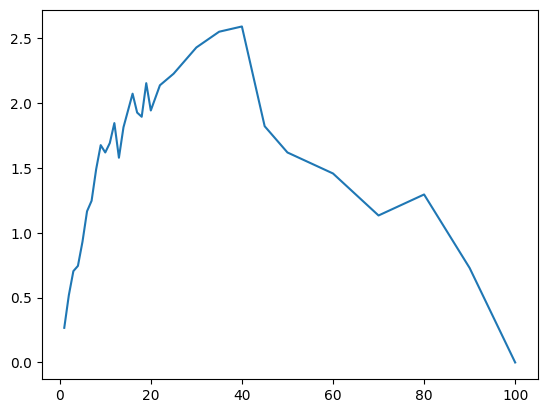

In [52]:
#Load pickle
with open("/NL/token-pricing/work/src/heuristic_model_Llama-3.2-1B-Instruct_T_1.5_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_1_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data = pickle.load(f)



splits = [1,2,3,4,5,6,7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20 ,22 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100]

percentage = np.array( [ data["top_p_count"][0][i]  * splits[i] / sum(data["generated_outputs"][0]) * 100  for i in range( len(splits))] ) 

sns.lineplot(x = splits, y = percentage)    

<Axes: >

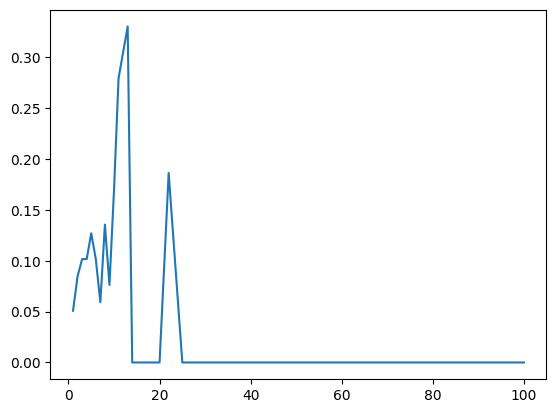

In [53]:
#Load pickle
with open("/NL/token-pricing/work/src/heuristic_model_Llama-3.2-1B-Instruct_T_1.2_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_1_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data = pickle.load(f)



splits = [1,2,3,4,5,6,7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20 ,22 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100]

percentage = np.array( [ data["top_p_count"][0][i]  * splits[i] / sum(data["generated_outputs"][0]) * 100  for i in range( len(splits))] ) 

sns.lineplot(x = splits, y = percentage)    